In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.tsa.seasonal as sts
import statsmodels.graphics.tsaplots as splt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.api import VAR
from datetime import datetime
transactions_path = "../favorita-grocery-sales-forecasting/transactions.csv"
holidays_path = "../favorita-grocery-sales-forecasting/holidays_events.csv"

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. For this section, plans is to expirement with Dr. Elston's suggestion of using Vector Autoregression (VAR). To complete this step, I need to create columns representing each store and its transaction. Then, as a test I can use the VAR model on the data.  </span>
</div>

In [2]:
transactions_df = pd.read_csv(transactions_path)

In [3]:
transactions_df.sample(3)

,date,store_nbr,transactions
68298,2016-11-01,54,1013
61861,2016-06-30,41,870
69437,2016-11-23,53,985


In [4]:
transactions_df.set_index(['date'], inplace=True)

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1.The following code creates a new field/column in the matrix of a stores transactions for a specific day, which is the index. If the index (date) does not exist for the store, then the mean transactions for that store is used.  </span>
</div>

In [5]:
stores = transactions_df.store_nbr.unique()

In [6]:
for number in stores:
    field = f"store_{number}_transactions"
    transactions_df[field] = round(transactions_df[transactions_df.store_nbr==int(number)].transactions.mean())
    for index, row in transactions_df.iterrows():
        if number == row['store_nbr']:
            transaction = row['transactions']
            transactions_df.loc[index, field] = transaction

In [7]:
transactions_df.drop(['store_nbr', 'transactions'], axis=1, inplace=True)

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. Let's look at an example of one the stores that has the most transactions based on the EDA. The plot looks very similar to the aggregated plot in our earlier EDA</span>
</div>

<AxesSubplot:xlabel='date'>

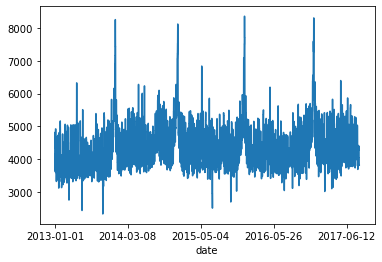

In [9]:
transactions_df['store_44_transactions'].plot()

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. Following the documentation for VAR, let's initiate and fit the model-- the number of lags is a guess at this point----and based on weekly shopping habits in the EDA</span>
</div>

In [10]:
model = VAR(transactions_df)

/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
results = model.fit(7)

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. I do not know how to get the plotting on this right?</span>
</div>

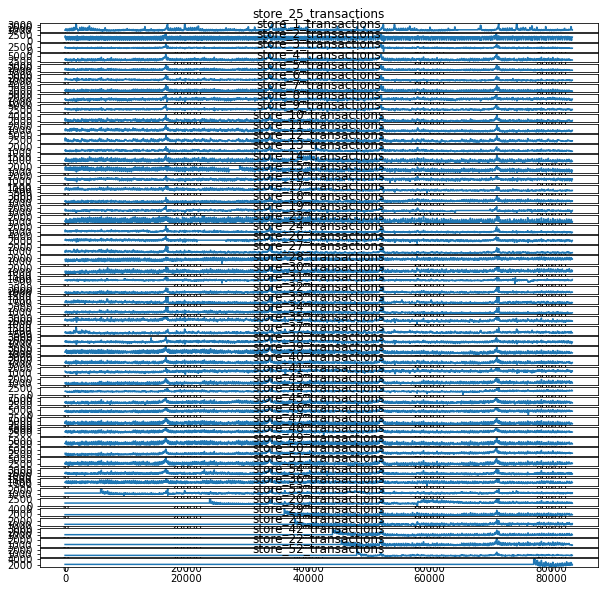

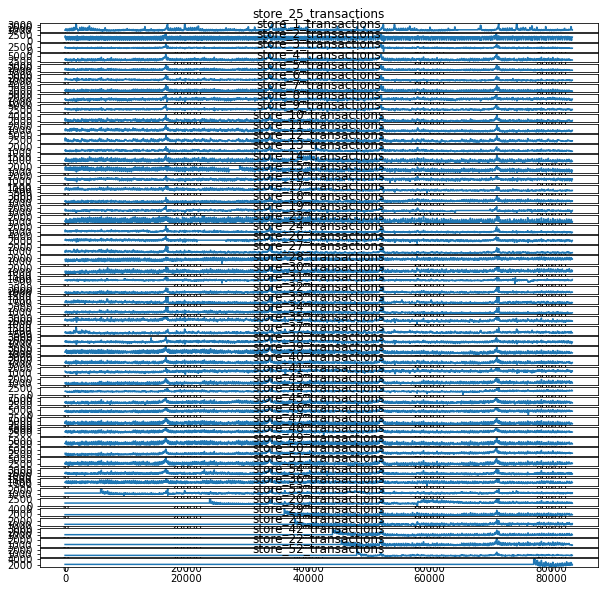

In [12]:
results.plot()

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. Now comes an aggregated effort to follow Dr. Elston's instructions on ED  </span>
</div>

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 1. The first step is to adjust all the series so that they have unit variance. This step makes the subsequent adjustments to the time series scale independent.  </span>
</div>

In [25]:
transactions_df = pd.read_csv(transactions_path)

In [26]:
#average transactions in the dataset
mean_transaction = transactions_df.transactions.mean()

#std deviation for the dataset
std_transaction = transactions_df.transactions.std()

transactions_wUnitVariance = (transactions_df.transactions - mean_transaction)/std_transaction

transactions_df['unit_variance_transactions'] = transactions_wUnitVariance

transactions_df.sample(3)

,date,store_nbr,transactions,unit_variance_transactions
33733,2014-12-24,27,2441,0.774845
69500,2016-11-25,10,683,-1.050157
27878,2014-08-24,7,1473,-0.230048


<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 2. You will need a trend model for each time series. This can be as simple as a linear regression model, or maybe a low-order polynomial model. Once you have the trend component, subtract it from each series to apply the adjustment.  </span>
</div>

In [27]:
dates = transactions_df.date.unique()
days = []
days_transactions = []
for date in dates:
    days.append(date)
    days_transactions.append(transactions_df[transactions_df.date == date].unit_variance_transactions.sum())
data = {'date': days,
        'transactions': days_transactions}
day_transactions_df = pd.DataFrame(data)
day_transactions_df['Date'] = pd.to_datetime(day_transactions_df['date'])

In [28]:
day_transactions_df.sample(3)

,date,transactions,Date
875,2015-05-28,-10.240468,2015-05-28
136,2013-05-17,-5.129627,2013-05-17
960,2015-08-21,-2.969326,2015-08-21


In [29]:
baseDF = day_transactions_df[['Date',  'transactions']].copy()
baseDF.rename(columns={'Date':'date'}, inplace=True)
baseDF.set_index('date', inplace=True)
t_times = len(baseDF.index)
baseDF['time_t'] = np.arange(t_times)
time_t = baseDF.loc[:, ['time_t']]
y = baseDF.loc[:, 'transactions']
y, time_t = y.align(time_t, join='inner') 

In [30]:
#Fit Linear Regression Model
reg = LinearRegression().fit(time_t, y)
trend = pd.Series(reg.predict(time_t), index=time_t.index)

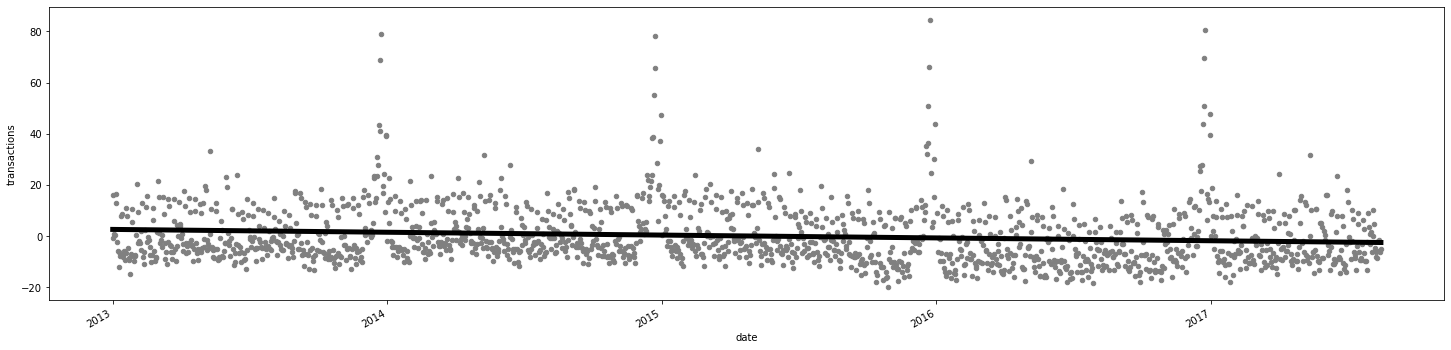

In [31]:
ax=day_transactions_df.plot(kind='scatter', x='Date', y='transactions', figsize=(25,6), color="grey")
_ = trend.plot(color="black", ax = ax,lw=5)

In [32]:
y_untrended = y - trend

In [33]:
detrended = y_untrended.reset_index().rename(columns={0:"detrended"}).drop(['date'], axis=1)
detrended

,detrended
0,-3.518120
1,13.289790
2,-1.978841
3,-1.986179
4,13.670565
...,...
1677,0.513981
1678,0.907355
1679,-3.173536
1680,-3.736263


In [34]:
day_transactions_df['detrended_transactions'] = detrended

In [35]:
day_transactions_df.head(3)

,date,transactions,Date,detrended_transactions
0,2013-01-01,-0.959841,2013-01-01,-3.518120
1,2013-01-02,15.845025,2013-01-02,13.289790
2,2013-01-03,0.573350,2013-01-03,-1.978841


<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 3. Adjust for seasons  </span>
</div>

In [36]:
#DATES IN THE DATA
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
            4:'Friday', 5:'Saturday', 6:'Sunday'}
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 
          5:'May', 6:'Jun', 7:'Jul',
          8: 'Aug', 9:'Sep', 10:'Oct', 11:'Nov',
          12:'Dec'}
day_transactions_df['day_of_week'] = [weekdays[date.weekday()] for date in day_transactions_df['Date']]
day_transactions_df['month'] = [months[date.month] for date in day_transactions_df['Date']]
day_transactions_df['year'] = [str(date.year) for date in day_transactions_df['Date']]

In [37]:
day_transactions_df.sample(3)

,date,transactions,Date,detrended_transactions,day_of_week,month,year
1432,2016-12-08,-7.540761,2016-12-08,-5.740378,Thursday,Dec,2016
1531,2017-03-18,9.633774,2017-03-18,11.735489,Saturday,Mar,2017
412,2014-02-18,-6.444916,2014-02-18,-7.749166,Tuesday,Feb,2014


In [38]:
holiday_df = pd.read_csv(holidays_path)

In [39]:
#HOLIDAYS IN THE DATA
Hs = list(holiday_df['date'].unique())

new_years_2 = ['2013-12-30', '2014-12-30', '2015-12-30', '2016-12-30', '2017-12-30']
new_years_1 = ['2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31']
new_years_0 = ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01','2017-01-01', 
               '2016-01-04']

mothers_day_celebrations =['2013-05-11', '2014-05-10','2015-05-09','2016-05-07', 
                           '2017-05-13']

Navidad_6 = ['2013-12-19', '2014-12-19', '2015-12-19', '2016-12-19', '2017-12-19']
Navidad_5 = ['2013-12-20', '2014-12-20', '2015-12-20', '2016-12-20', '2017-12-20']
Navidad_4 = ['2013-12-21', '2014-12-21', '2015-12-21', '2016-12-21', '2017-12-21']
Navidad_3 = ['2014-12-22', '2015-12-22', '2016-12-22', '2017-12-22']
Navidad_2 = ['2013-12-23', '2014-12-23', '2015-12-23', '2016-12-23', '2017-12-23']
Navidad_1 = ['2013-12-24', '2014-12-24', '2015-12-24', '2016-12-24', '2017-12-24']
Navidad_0 = ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25']
Navidadp1 = ['2013-12-26', '2014-12-26', '2015-12-26', '2016-12-26', '2017-12-26']


significant_dates = new_years_0 + new_years_1 + new_years_2 + \
                    mothers_day_celebrations + Navidad_4 + Navidad_3 + \
                    Navidad_2 + Navidad_1 + Navidad_0 + Navidadp1

holidays = []
for h in Hs:
    if h not in significant_dates:
        holidays.append(h)

In [40]:
day_transactions_df['holiday'] = [1 if (holiday in holidays) else 0 for holiday in day_transactions_df['date']]
day_transactions_df['new_years_1_2'] = [1 if (ny in new_years_1 + new_years_2) else 0 for ny in day_transactions_df['date']]
day_transactions_df['new_year'] = [1 if (ny in new_years_0) else 0 for ny in day_transactions_df['date']]
day_transactions_df['mothers_celebration'] = [1 if (day in mothers_day_celebrations) else 0 for day in day_transactions_df['date']]
day_transactions_df['Navidad_6'] = [1 if (day in Navidad_6) else 0 for day in day_transactions_df['date']]
day_transactions_df['Navidad_5'] = [1 if (day in Navidad_5) else 0 for day in day_transactions_df['date']]
day_transactions_df['Navidad_4'] = [1 if (day in Navidad_4) else 0 for day in day_transactions_df['date']]
day_transactions_df['Navidad_3'] = [1 if (day in Navidad_3) else 0 for day in day_transactions_df['date']]
day_transactions_df['Navidad_2'] = [1 if (day in Navidad_2) else 0 for day in day_transactions_df['date']]
day_transactions_df['Navidad_1'] = [1 if (day in Navidad_1) else 0 for day in day_transactions_df['date']]
day_transactions_df['Navidad_0'] = [1 if (day in Navidad_0) else 0 for day in day_transactions_df['date']]
day_transactions_df['Navidadp1'] = [1 if (day in Navidadp1) else 0 for day in day_transactions_df['date']]

In [42]:
day_transactions_df.sample(1)

,date,transactions,Date,detrended_transactions,day_of_week,month,year,holiday,new_years_1_2,new_year,mothers_celebration,Navidad_6,Navidad_5,Navidad_4,Navidad_3,Navidad_2,Navidad_1,Navidad_0,Navidadp1
1251,2016-06-10,-9.870286,2016-06-10,-8.620823,Friday,Jun,2016,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
#break out of categorical and numerical values
categorical_features = ['day_of_week', 'month', 'year']
numerical_features = ['detrended_transactions', 'holiday', 'new_years_1_2', 'new_year', 'mothers_celebration',
                      'Navidad_6', 'Navidad_5', 'Navidad_4', 'Navidad_3', 'Navidad_2', 'Navidad_1', 'Navidad_0', 'Navidadp1']

In [44]:
temp = pd.get_dummies(day_transactions_df, columns = categorical_features, drop_first = True)
temp.columns

Index(['date', 'transactions', 'Date', 'detrended_transactions', 'holiday',
       'new_years_1_2', 'new_year', 'mothers_celebration', 'Navidad_6',
       'Navidad_5', 'Navidad_4', 'Navidad_3', 'Navidad_2', 'Navidad_1',
       'Navidad_0', 'Navidadp1', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'month_Aug', 'month_Dec', 'month_Feb',
       'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May',
       'month_Nov', 'month_Oct', 'month_Sep', 'year_2014', 'year_2015',
       'year_2016', 'year_2017'],
      dtype='object')

In [45]:
wanted_fields = ['Date', 'detrended_transactions', 'holiday',
                 'new_years_1_2', 'new_year', 'mothers_celebration', 'Navidad_6',
                 'Navidad_5', 'Navidad_4', 'Navidad_3', 'Navidad_2', 'Navidad_1',
                 'Navidad_0', 'Navidadp1', 'day_of_week_Monday', 'day_of_week_Saturday',
                 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
                 'day_of_week_Wednesday', 'month_Aug', 'month_Dec', 'month_Feb',
                 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May',
                 'month_Nov', 'month_Oct', 'month_Sep', 'year_2014', 'year_2015',
                 'year_2016', 'year_2017']

In [46]:
X = temp[wanted_fields].copy()
X.rename(columns={'Date':'date', 'unit_varianced_transactions': 'transactions'}, inplace=True)
X.set_index('date', inplace=True)
t_times = len(X.index)
X['time_t'] = np.arange(t_times)
#time_t = X.loc[:, ['time_t']]
y = X.loc[:, 'detrended_transactions']
#y, time_t = y.align(time_t, join='inner')

In [47]:
X = X.drop(['detrended_transactions'], axis=1)

In [48]:
#Fit Linear Regression Model
reg = LinearRegression().fit(X, y)
season = pd.Series(reg.predict(X), index=X.index)

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> 3. Taking a peek at the results here...   </span>
</div>

In [49]:
season

date
2013-01-01    -5.814767
2013-01-02    -3.640452
2013-01-03    -7.308952
2013-01-04    -1.976314
2013-01-05    13.003701
                ...    
2017-08-11    -1.394976
2017-08-12    12.975494
2017-08-13     8.290670
2017-08-14    -3.574048
2017-08-15    -5.559495
Length: 1682, dtype: float64

In [50]:
y

date
2013-01-01    -3.518120
2013-01-02    13.289790
2013-01-03    -1.978841
2013-01-04    -1.986179
2013-01-05    13.670565
                ...    
2017-08-11     0.513981
2017-08-12     0.907355
2017-08-13    -3.173536
2017-08-14    -3.736263
2017-08-15    -2.577800
Name: detrended_transactions, Length: 1682, dtype: float64

In [54]:
unseason = y - season

In [55]:
y[350:370]

date
2013-12-17    13.514717
2013-12-18    22.085304
2013-12-19    29.262744
2013-12-20    26.121345
2013-12-21    41.890205
2013-12-22    39.372711
2013-12-23    67.279183
2013-12-24    77.632210
2013-12-26    15.510443
2013-12-27    17.930213
2013-12-28    22.633831
2013-12-29     7.969382
2013-12-30    37.990489
2013-12-31    37.546106
2014-01-01    -3.591151
2014-01-02    11.803474
2014-01-03     3.581965
2014-01-04    21.101082
2014-01-05    12.917570
2014-01-06    -3.368411
Name: detrended_transactions, dtype: float64

In [56]:
season[350:370]

date
2013-12-17     1.148082
2013-12-18     2.215919
2013-12-19    18.854650
2013-12-20    25.460478
2013-12-21    49.532239
2013-12-22    14.175248
2013-12-23    67.485443
2013-12-24    75.843815
2013-12-26    13.644977
2013-12-27     2.652162
2013-12-28    17.327405
2013-12-29    12.642581
2013-12-30    39.252975
2013-12-31    36.962755
2014-01-01    -2.148126
2014-01-02    -4.710148
2014-01-03     0.622491
2014-01-04    15.297733
2014-01-05    10.612909
2014-01-06    -1.251808
dtype: float64

In [57]:
unseason[350:370]

date
2013-12-17    12.366635
2013-12-18    19.869386
2013-12-19    10.408094
2013-12-20     0.660867
2013-12-21    -7.642035
2013-12-22    25.197463
2013-12-23    -0.206260
2013-12-24     1.788395
2013-12-26     1.865466
2013-12-27    15.278051
2013-12-28     5.306426
2013-12-29    -4.673199
2013-12-30    -1.262486
2013-12-31     0.583352
2014-01-01    -1.443025
2014-01-02    16.513622
2014-01-03     2.959474
2014-01-04     5.803350
2014-01-05     2.304661
2014-01-06    -2.116602
dtype: float64

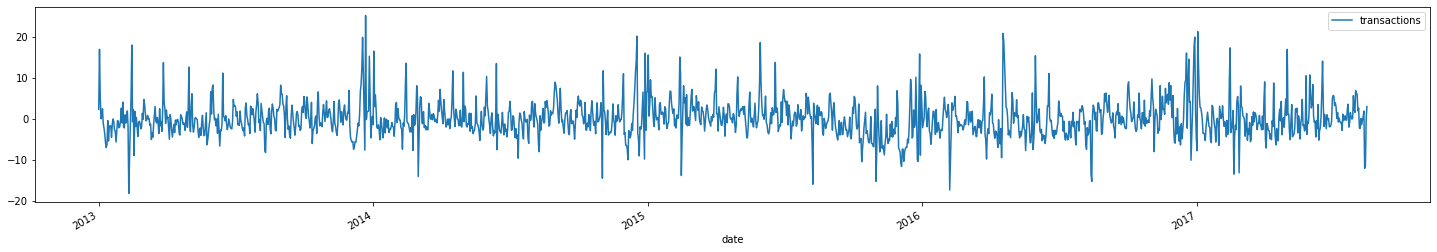

In [59]:
y_unseason = pd.DataFrame(unseason)
y_unseason.rename(columns={0:'transactions'}, inplace=True)
_=y_unseason.plot(figsize=(25,4))

In [60]:
y_unseason[y_unseason.transactions==y_unseason.transactions.max()]

,transactions
date,
2013-12-22,25.197463


<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> Decomposing the information should show a straight line for the trend, 
                                  which I look at below. Additional adjustment work is needed...</span>
</div>

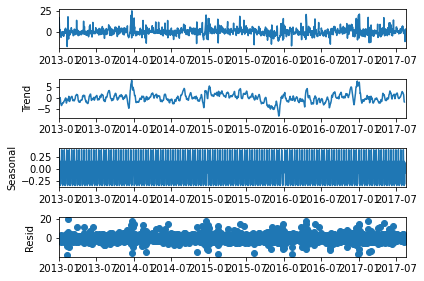

In [61]:
def decomp_ts(ts, model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model, period=12) 
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                          index = ts.index) )

decomp = decomp_ts(y_unseason, model='additive')

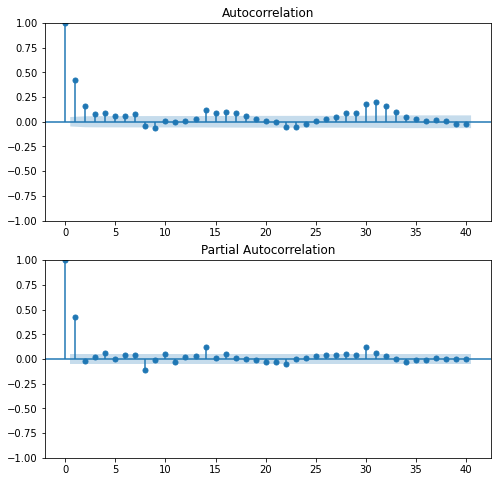

In [62]:
def auto_partial_corr_plot(ts):
    _,ax = plt.subplots(2,1, figsize=(8,8))
    _=splt.plot_acf(ts, lags = 40, ax=ax[0]);
    _=splt.plot_pacf(ts, lags = 40, method='yw', ax=ax[1]);

auto_partial_corr_plot(y_unseason)

        Values                       Metric
0   -26.203711               D-F Statistics
1     0.000000                      p-value
2     0.000000          number of lags used
3  1681.000000  Number of observations used
4    -3.434246          critical value (1%)
5    -2.863261          critical value (5%)
6    -2.567686         critical value (10%)


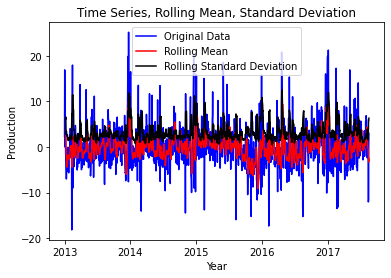

In [63]:
def test_stationarity(df):
    
    # Plot rolling mean and std
    rolling_mean = df.rolling(7).mean()
    rolling_std = df.rolling(7).std()
    
    plt.plot(df, color="blue",label="Original Data")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation")
    plt.xlabel('Year')
    plt.ylabel('Production')
    plt.title("Time Series, Rolling Mean, Standard Deviation")
    plt.legend(loc="best")
    
    # use the augmented Dickey-Fuller test from the statsmodels package. 
    adft = adfuller(df,autolag='BIC')

    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  ,
                              "Metric":["D-F Statistics","p-value","number of lags used","Number of observations used",
                              "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    return print(output_df)
test_stationarity(y_unseason)

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> The p-value resulting from the Augmented Dickey-Fuller test
                                  is very low showing that the time series is stationary.
                            </span>
</div>

In [66]:
def model_ARIMA(ts, order):
    model = ARIMA(ts, order=order, )
 #   model_fit = model.fit(disp=0, method='mle', trend='nc')
    model_fit = model.fit()
    print(model_fit.summary())
    return(model_fit)
model = model_ARIMA(y_unseason, order = (5,0,0))

/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/csci_e83/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           transactions   No. Observations:                 1682
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -4714.539
Date:                Sun, 04 Dec 2022   AIC                           9443.079
Time:                        21:25:23   BIC                           9481.073
Sample:                             0   HQIC                          9457.152
                               - 1682                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.191      0.002      0.998      -0.373       0.374
ar.L1          0.4262      0.016     26.572      0.000       0.395       0.458
ar.L2         -0.0259      0.021     -1.219      0.2

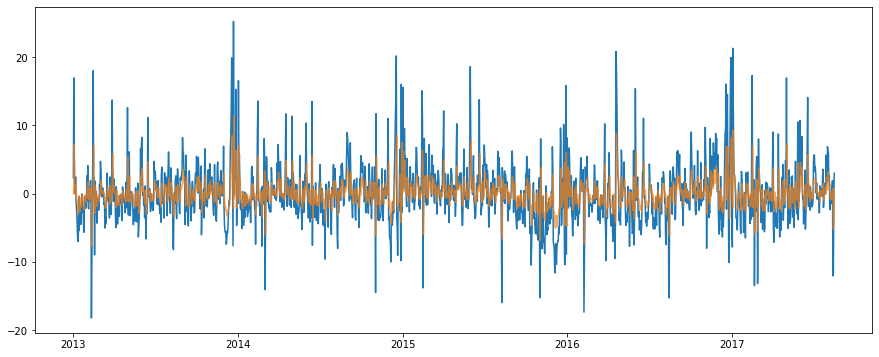

In [67]:
plt.figure(figsize=(15,6))
plt.subplot
plt.plot(y_unseason);
plt.plot(model.fittedvalues,alpha=.7);